In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment','Transect','Peak_Dist', 'Transect_Num'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
experiment_metadata = pd.read_csv('data_summary.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
experiment_metadata = experiment_metadata[experiment_metadata['Experiment'] == experiment]
wind_dir = experiment_metadata['Wind_Dir'].values[0]
wind_speed = experiment_metadata['WindSpeed'].values[0]

# Converting lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - experiment_metadata['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - experiment_metadata['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']
print(all_data.Concentration)

0       286.732816
1       237.105414
2       226.279577
3       235.301059
4       246.127481
           ...    
8742    287.597213
8743    277.640603
8744    272.209975
8745    287.597213
8746    255.014150
Name: Concentration, Length: 8747, dtype: float64


In [2]:
print('x',np.min(all_data['x']), np.max(all_data['x']))
print('y',np.min(all_data['y']), np.max(all_data['y']))
print('z',np.min(all_data['z']), np.max(all_data['z']))

x 238.4238678254004 1267.6752043139904
y -890.0043524753258 151.27800656802194
z 11.2 200.8


In [3]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ZeroMean
from gpytorch.kernels import RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from sklearn.model_selection import train_test_split
from gpytorch.mlls import ExactMarginalLogLikelihood




# Converting Dataframe to pytorch tensor
data = torch.tensor(all_data[['x', 'y', 'z']].values, dtype=torch.float32)
labels = torch.tensor(all_data['Concentration'].values, dtype=torch.float32)

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the GP Model
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ZeroMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Define the likelihood function
likelihood = GaussianLikelihood()

# Define the model and move to cuda
model = GPModel(X_train, y_train, likelihood)

# Define the optimizer
optimizer = torch.optim.Adam([ {'params': model.parameters()}], lr=0.1)

# Define the mll (Marginal Log Likelihood)
mll = ExactMarginalLogLikelihood(likelihood, model)

# Training loop
training_iterations = 50
for i in range(training_iterations):
    print('Iteration ' + str(i + 1))
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad():
    test_preds = likelihood(model(X_test))


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50


In [24]:
import matplotlib.pyplot as plt

# Generate test inputs
test_x_lin = torch.range(200, 1300, 10)
test_y_lin = torch.range(-200, 200, 10)
test_z_lin = torch.range(0, 200, 10)
test_x, test_y, test_z = torch.meshgrid(test_x_lin, test_y_lin, test_z_lin)
test_x = test_x.reshape(-1)
test_y = test_y.reshape(-1)
test_z = test_z.reshape(-1)

C:\Users\Sam\AppData\Local\Temp\ipykernel_21216\2560559622.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  test_x_lin = torch.range(200, 1300, 10)
C:\Users\Sam\AppData\Local\Temp\ipykernel_21216\2560559622.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  test_y_lin = torch.range(-200, 200, 10)
C:\Users\Sam\AppData\Local\Temp\ipykernel_21216\2560559622.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  test_z_lin = torch.range(0, 200, 10)


In [34]:
# Extract the test points with z = z*
z_value = 0
idx = (test_z == z_value)

test_indep = torch.stack([test_x[idx], test_y[idx], test_z[idx]], dim=-1)

# Make predictions
with torch.no_grad():
    preds = model(test_indep)

# Extract mean and standard deviation
mean = preds.mean.numpy().reshape(len(test_x_lin),len(test_y_lin))
std = preds.stddev.numpy().reshape(len(test_x_lin),len(test_y_lin))


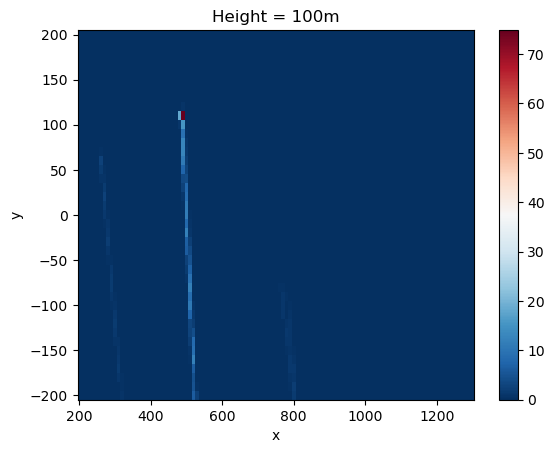

In [35]:
# Plot the results
X0, X1 = test_x[idx].reshape(len(test_x_lin),len(test_y_lin)), test_y[idx].reshape(len(test_x_lin),len(test_y_lin))

plt.pcolormesh(X0, X1, mean,cmap='RdBu_r',shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Height = ' + str(z_value) + 'm')
plt.show()

In [32]:
# Extract the test points with x = x*
x_value = 500
idx = (test_x == x_value)

test_indep = torch.stack([test_x[idx], test_y[idx], test_z[idx]], dim=-1)

# Make predictions
with torch.no_grad():
    preds = model(test_indep)

# Extract mean and standard deviation
mean = preds.mean.numpy().reshape(len(test_y_lin),len(test_z_lin))
std = preds.stddev.numpy().reshape(len(test_y_lin),len(test_z_lin))


[ 200.  210.  220.  230.  240.  250.  260.  270.  280.  290.  300.  310.
  320.  330.  340.  350.  360.  370.  380.  390.  400.  410.  420.  430.
  440.  450.  460.  470.  480.  490.  500.  510.  520.  530.  540.  550.
  560.  570.  580.  590.  600.  610.  620.  630.  640.  650.  660.  670.
  680.  690.  700.  710.  720.  730.  740.  750.  760.  770.  780.  790.
  800.  810.  820.  830.  840.  850.  860.  870.  880.  890.  900.  910.
  920.  930.  940.  950.  960.  970.  980.  990. 1000. 1010. 1020. 1030.
 1040. 1050. 1060. 1070. 1080. 1090. 1100. 1110. 1120. 1130. 1140. 1150.
 1160. 1170. 1180. 1190. 1200. 1210. 1220. 1230. 1240. 1250. 1260. 1270.
 1280. 1290. 1300.]


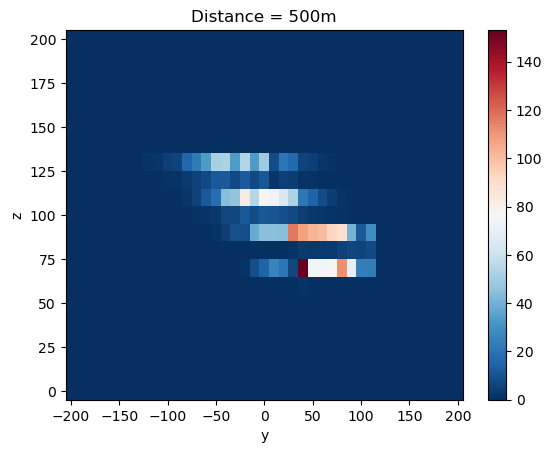

In [33]:
# Plot the results
X0, X1 = test_y[idx].reshape(len(test_y_lin),len(test_z_lin)), test_z[idx].reshape(len(test_y_lin),len(test_z_lin))

plt.pcolormesh(X0, X1, mean,cmap='RdBu_r',shading='auto')
plt.colorbar()
plt.xlabel('y')
plt.ylabel('z')
plt.title('Distance = ' + str(x_value) + 'm')
plt.show()

In [36]:
# Extract the test points with x = x*
y_value = 0
idx = (test_y == y_value)

test_indep = torch.stack([test_x[idx], test_y[idx], test_z[idx]], dim=-1)

# Make predictions
with torch.no_grad():
    preds = model(test_indep)

# Extract mean and standard deviation
mean = preds.mean.numpy().reshape(len(test_x_lin),len(test_z_lin))
std = preds.stddev.numpy().reshape(len(test_x_lin),len(test_z_lin))


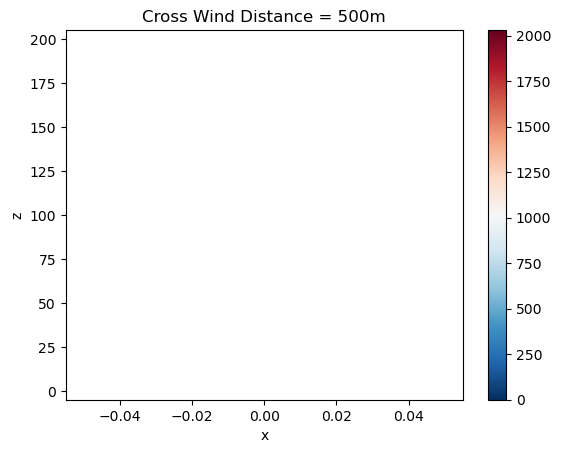

In [37]:
# Plot the results
X0, X1 = test_y[idx].reshape(len(test_x_lin),len(test_z_lin)), test_z[idx].reshape(len(test_x_lin),len(test_z_lin))

plt.pcolormesh(X0, X1, mean,cmap='RdBu_r',shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('z')
plt.title('Cross Wind Distance = ' + str(x_value) + 'm')
plt.show()